In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline 

import os
from glob import glob
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
from scipy.optimize import lsq_linear
from sklearn.linear_model import LinearRegression
import pickle
import seaborn as sns

## Configuration

### Plotting styling

In [2]:
colors = {}
#Expert algos
colors['Threshold0'] = 'black'
colors['Threshold'] = 'black'
colors['Mixedbcstc'] = 'black'

#Electron Gun models
colors['AutoEncoderEMDAEMSEeleGun']   = 'tab:red'
colors['AutoEncoderEMDAEMSLEeleGun']  = 'tab:pink'
colors['AutoEncoderEMDAEHUBEReleGun'] = 'tab:purple'
colors['AutoEncoderTELEeleGun']  = 'tab:green'

#TTbar dataset with physics columns
colors['AutoEncoderEMDAEMSEnew'] = 'tab:orange'
colors['AutoEncoderTelenew'] = 'tab:blue'

#Nine bits in AE
colors ['AutoEncoderEMDAEMSEeleGunNineBits'] = 'tab:red'
colors ['AutoEncoderEMDAEMSEttbarNineBits']  = 'tab:orange'

styles = {}
styles['Threshold0'] = '--'
styles['Threshold'] = '-.'
styles['Mixedbcstc'] = '-.'

styles['AutoEncoderEMDAEMSEeleGun']   = '-'
styles['AutoEncoderEMDAEMSLEeleGun']  = '-'
styles['AutoEncoderEMDAEHUBEReleGun'] = '-'
styles['AutoEncoderTELEeleGun']  = '-'

styles['AutoEncoderEMDAEMSEnew'] = '-'
styles['AutoEncoderTelenew'] = '-'

styles['AutoEncoderEMDAEMSEeleGunNineBits'] = '--'
styles['AutoEncoderEMDAEMSEttbarNineBits']  = '--'

legends = {}
legends['Threshold0'] = 'All TC'
legends['Threshold'] = 'Threshold 1.35 mipT'
legends['Mixedbcstc'] = 'BC+STC'

legends['AutoEncoderEMDAEMSEeleGun']   = 'eGun: QAE EMD_MSE'
legends['AutoEncoderEMDAEMSLEeleGun']  = 'eGun: QAE EMD_MSLE'
legends['AutoEncoderEMDAEHUBEReleGun'] = 'eGun: QAE EMD_HUBER'
legends['AutoEncoderTELEeleGun']  = 'eGun: QAE TELE'

legends['AutoEncoderEMDAEMSEnew'] = 'TTbar: QAE EMD_MSE'
legends['AutoEncoderTelenew'] = 'TTbar: QAE TELE'

legends['AutoEncoderEMDAEMSEeleGunNineBits'] = 'eGun: QAE EMD_MSE 9'
legends['AutoEncoderEMDAEMSEttbarNineBits']  = 'TTbar: QAE EMD_MSE 9'


ref_name = 'Threshold0'

"""
Keys
1: 10_18_1 ['AutoEncoderStrideAEMSE', 'AutoEncoderStrideAppMSE', 'AutoEncoderStridePairHuber', 'AutoEncoderStridePairMSE', ]>
2: 11_8_1  ['AutoEncoderStrideAEHuber', 'AutoEncoderStrideAEMSLE', 'AutoEncoderStrideAPPHuber', 'AutoEncoderStrideAPPMSLE', ]
3: 11_22_1(QKERAS) = ['Threshold','Threshold0','Mixedbcstc','AutoEncoderTelescopeMSE','AutoEncoderEMDAEMSE','AutoEncoderEMDPAIRHUBER']
4: 12_04_21(QKERAS) = ['AutoEncoderEMDAEMSLE','AutoEncoderEMDAEHuber','AutoEncoderEMDPAIRMSE']
5: 12_18_21(QKERAS+ELINK SPECIFIC TRAINING): 'AutoEncoderEMDAEMSLE','AutoEncoderEMDPAIRMSE']
6: 01_26_22(QKERAS): 'AutoEncoderEMDAEMSLE22','AutoEncoderEMDAEMSE22,''AutoEncoderTelescopeMSE22','AutoEncoderEMDPAIRMSE22']
7: 04_05_22(QKeras): 'AutoEncoderEMDTPAIRMSE','AutoEncoderEMDTPAIRMSLE','AutoEncoderEMDTPAIRHUBER']
8: 04_15_22(Qkeras): 'AutoEncoderEMDAEMSEnew','AutoEncoderTelenew'
9: 06_06_22(Qkeras,egun): Threshold0, Mixedbcstc AutoencoderEMDMSEeleGun,AutoencoderEMDMSLEeleGun,AutoencoderEMDHUBEReleGun,AutoencoderEMDTELEeleGun,
10: 07_01_22(ttbar,egun,9bits): 'AutoEncoderEMDAEMSEeleGunNineBits', 'AutoEncoderEMDAEMSEttbarNineBits'

"""

"\nKeys\n1: 10_18_1 ['AutoEncoderStrideAEMSE', 'AutoEncoderStrideAppMSE', 'AutoEncoderStridePairHuber', 'AutoEncoderStridePairMSE', ]>\n2: 11_8_1  ['AutoEncoderStrideAEHuber', 'AutoEncoderStrideAEMSLE', 'AutoEncoderStrideAPPHuber', 'AutoEncoderStrideAPPMSLE', ]\n3: 11_22_1(QKERAS) = ['Threshold','Threshold0','Mixedbcstc','AutoEncoderTelescopeMSE','AutoEncoderEMDAEMSE','AutoEncoderEMDPAIRHUBER']\n4: 12_04_21(QKERAS) = ['AutoEncoderEMDAEMSLE','AutoEncoderEMDAEHuber','AutoEncoderEMDPAIRMSE']\n5: 12_18_21(QKERAS+ELINK SPECIFIC TRAINING): 'AutoEncoderEMDAEMSLE','AutoEncoderEMDPAIRMSE']\n6: 01_26_22(QKERAS): 'AutoEncoderEMDAEMSLE22','AutoEncoderEMDAEMSE22,''AutoEncoderTelescopeMSE22','AutoEncoderEMDPAIRMSE22']\n7: 04_05_22(QKeras): 'AutoEncoderEMDTPAIRMSE','AutoEncoderEMDTPAIRMSLE','AutoEncoderEMDTPAIRHUBER']\n8: 04_15_22(Qkeras): 'AutoEncoderEMDAEMSEnew','AutoEncoderTelenew'\n9: 06_06_22(Qkeras,egun): Threshold0, Mixedbcstc AutoencoderEMDMSEeleGun,AutoencoderEMDMSLEeleGun,AutoencoderEMDHUBE

### Input files and FE algorithms to be studied
Both 200PU electron gun and 0PU photon guns are loaded

In [19]:
version = 'egun_ttbar_9bits'

fig_dir = '/home/cms.rshenoy/Plots/electron_photon_calib_autoencoder_{}'.format(version)

if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

In [6]:
algo_files = {}
# Read  first set
directory1 = '/home/cms.rshenoy/10_18_1/electron_photon_signaldriven/v_1_2021-10-23'
directory2 = '/home/cms.rshenoy/11_8_1/electron_photon_signaldriven/v_1_2021-11-08'
directory3 = '/home/cms.rshenoy/11_22_1/electron_photon_signaldriven/v_1_2021-12-01'
directory4 = '/home/cms.rshenoy/12_04_21/electron_photon_signaldriven/v_1_2021-12-05'
directory5 = '/home/cms.rshenoy/12_18_21/electron_photon_signaldriven/v_1_2021-12-18'
directory6 = '/home/cms.rshenoy/01_26_22/electron_photon_signaldriven/v_1_2022-01-27'
directory7 = '/home/cms.rshenoy/04_05_22/electron_photon_signaldriven/v_1_2022-04-06'
directory8 = '/home/cms.rshenoy/04_15_22/electron_photon_signaldriven/v_1_2022-04-16'
directory9 = '/home/cms.rshenoy/06_06_22a/electron_photon_signaldriven/v_1_2022-06-06'
directory10 = '/home/cms.rshenoy/07_01_22/electron_photon_signaldriven/v_1_2022-07-03'


fes=['AutoEncoderEMDAEMSEeleGun','AutoEncoderEMDAEMSEnew','AutoEncoderEMDAEMSEeleGunNineBits','AutoEncoderEMDAEMSEttbarNineBits']

In [7]:
for fe in fes:
    if(fe=='AutoEncoderEMDAEMSEnew'or fe=='AutoEncoderTelenew'):
        algo_files[fe] = (glob(directory8+'/electrons/*.hdf5'), glob(directory8+'/photons/*.hdf5'))
    elif(fe=='AutoEncoderEMDAEMSEeleGunNineBits'or fe=='AutoEncoderEMDAEMSEttbarNineBits'):
        algo_files[fe] = (glob(directory10+'/electrons/*.hdf5'), glob(directory10+'/photons/*.hdf5'))
    else:
        algo_files[fe] = (glob(directory9+'/electrons/*.hdf5'), glob(directory9+'/photons/*.hdf5'))

## Loading and preprocessing dataframes

In [8]:
algos_dfs = {}
for fe,files in algo_files.items():
    name = fe
    dfs = []
    for file in files[0]:
        store = pd.HDFStore(file, mode='r')
        dfs.append(store[name])
        store.close()
    for file in files[1]:
        store = pd.HDFStore(file, mode='r')
        dfs.append(store[name])
        store.close()
    algos_dfs[fe] = pd.concat(dfs)
algo_names = sorted(algos_dfs.keys())

Selection cuts (in addition to those already applied before):
- Gen particle $p_T > 5 GeV$
- Cluster $p_T > 3 GeV$
- Extrapolated gen particle eta between 1.6 and 2.9

Additionally label electrons and positrons as `0` and photons as `1`.

In [9]:
ptcut=5
clptcut=3
etamin=1.6
etamax=2.9
algo_cut={}
for name,df in algos_dfs.items():
    sel = df['genpart_pt']>ptcut
    algo_cut[name] = df[sel]
    sel = algo_cut[name]['cl3d_pt']>clptcut
    algo_cut[name] = algo_cut[name][sel]
    sel = np.abs(algo_cut[name]['genpart_exeta'])>etamin
    algo_cut[name] = algo_cut[name][sel]
    sel = np.abs(algo_cut[name]['genpart_exeta'])<etamax
    algo_cut[name] = algo_cut[name][sel]
    sel = algo_cut[name]['matches']==True
    algo_cut[name] = algo_cut[name][sel]
    #algo_cut[name].dropna(inplace=True)
    algo_cut[name]['genpart_pid'].replace([-11,11],1, inplace=True)
    algo_cut[name]['genpart_pid'].replace([22],0, inplace=True)

In [10]:
for name,df in algo_cut.items():
    df['cl3d_abseta'] = np.abs(df.cl3d_eta)

## Energy corrections
### Layer weights
On 0PU photon clusters:
- Select layer pTs in the ECAL, dropping the first layer as it doesn't bring anything in the e/g energy and is polluted by PU
- Apply linear regression to find multiplicative coeff. to be applied to each layer pT. These coeff. are bounded between 0 and 2 to avoid large correction factors

In [13]:
layer_coeffs = {}
for name,df in algo_cut.items():
    # select layers [2,14]
    select = df.query('genpart_pid==0')
    print(name)
    print(select['cl3d_layer_pt'])
    layers = np.array(select['cl3d_layer_pt'].tolist())[:,2:15]
    regression = lsq_linear(layers, select['genpart_pt'],
                              bounds = (0.,2.0),
                              method='bvls',
                              lsmr_tol='auto',
                              verbose=1)
    layer_coeffs[name] = regression.x
    print(regression.x)

AutoEncoderEMDAEMSEeleGun
event
6920     [0.0, 0.0, 0.886272132396698, 4.97293376922607...
6923     [0.0, 0.009934964589774609, 0.7150329947471619...
6926     [0.0, 0.0, 0.004313828889280558, 0.69808262586...
6926     [0.0, 0.00866301916539669, 0.797160267829895, ...
6935     [0.0, 0.004284483380615711, 0.8781248927116394...
                               ...                        
11342    [0.0, 0.0, 0.0, 0.0, 0.018379652872681618, 0.3...
11342    [0.0, 0.0017468560254201293, 0.264648705720901...
11345    [0.0, 0.005136310588568449, 0.3798844516277313...
11345    [0.0, 0.0, 0.026642590761184692, 0.20619542896...
11362    [0.0, 0.005593207664787769, 0.2334579527378082...
Name: cl3d_layer_pt, Length: 446, dtype: object
The relative change of the cost function is less than `tol`.
Number of iterations 8, initial cost 1.1973e+04, final cost 6.1805e+03, first-order optimality 3.34e-10.
[1.39744064 1.79403505 0.56131216 1.01344724 1.25843503 1.09725737
 0.82930143 1.2524996  1.34299844 0.  

Apply layer weights and compute ratios wrt the gen $p_T$ and plot the weight values

In [14]:
# Apply calibration
for name,df in algo_cut.items():
    layers = np.array(df['cl3d_layer_pt'].tolist())[:,2:15]
    df['cl3d_pt_calib'] = np.dot(layers, layer_coeffs[name])
    df['cl3d_over_gen_pt'] = df['cl3d_pt']/df['genpart_pt']
    df['calib_over_gen_pt'] = df['cl3d_pt_calib']/df['genpart_pt']

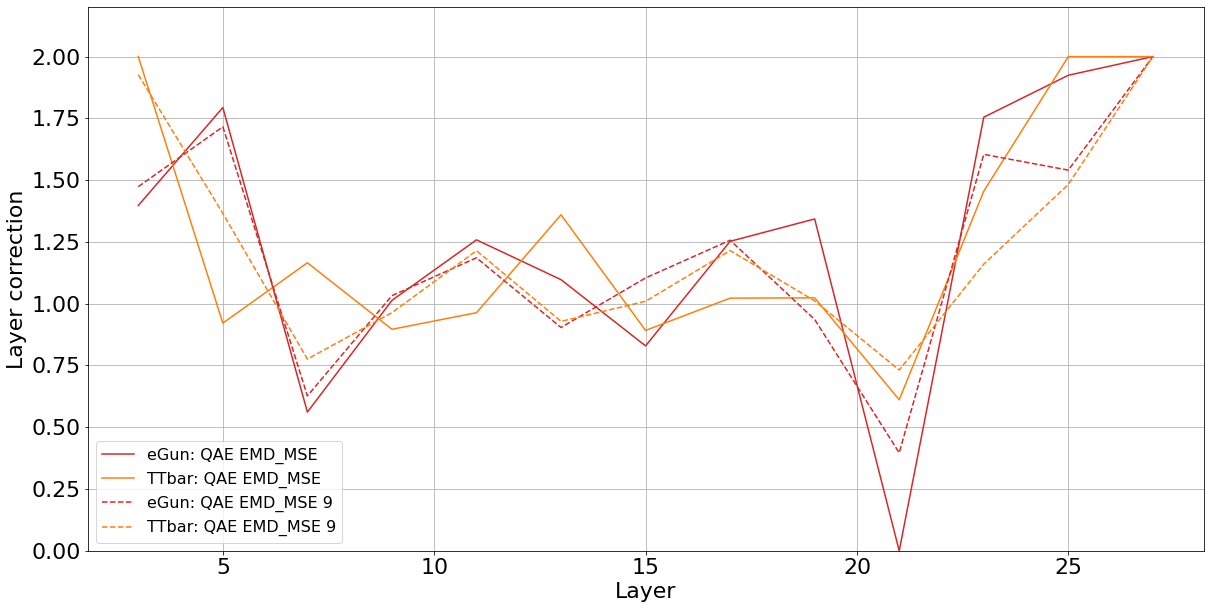

In [20]:
matplotlib.rcParams.update({'font.size': 22})
plt.figure(figsize=(20,10))
for name,weights in layer_coeffs.items():
    plt.plot(range(3, 29, 2), weights, label=legends[name], color=colors[name], ls=styles[name])
plt.ylim(0., 2.2)
plt.legend(fontsize=16)
plt.grid()
plt.xlabel('Layer')
plt.ylabel('Layer correction')
plt.savefig(fig_dir+'/layer_corrections.png')
plt.show()


Check impact of layer corrections on the energy ratio distributions

Raw mean=0.9325817227363586, rms=0.037840913981199265, rms/mean=0.0405765138566494
Calib mean=0.9977138476347736, rms=0.0443789939455292, rms/mean=0.04448068356546929


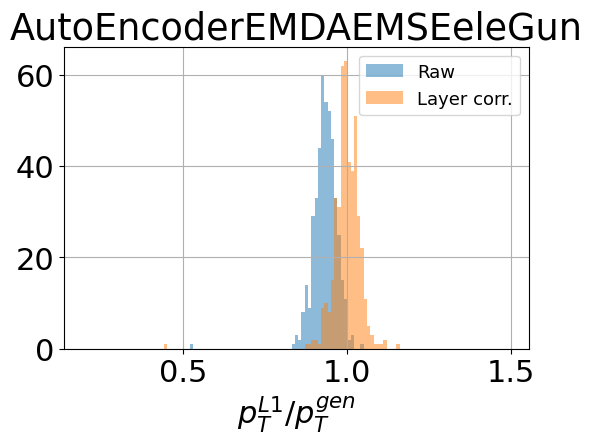

Raw mean=0.9440127015113831, rms=0.03468744084239006, rms/mean=0.036744676530361176
Calib mean=0.9971915455638085, rms=0.04194724979707231, rms/mean=0.04206538852408289


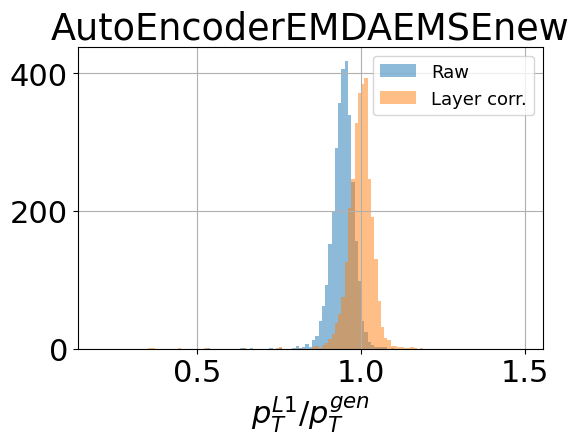

Raw mean=0.9498287439346313, rms=0.03703851252794266, rms/mean=0.038994938135147095
Calib mean=0.9976151302709082, rms=0.04407334977280719, rms/mean=0.04417871024153254


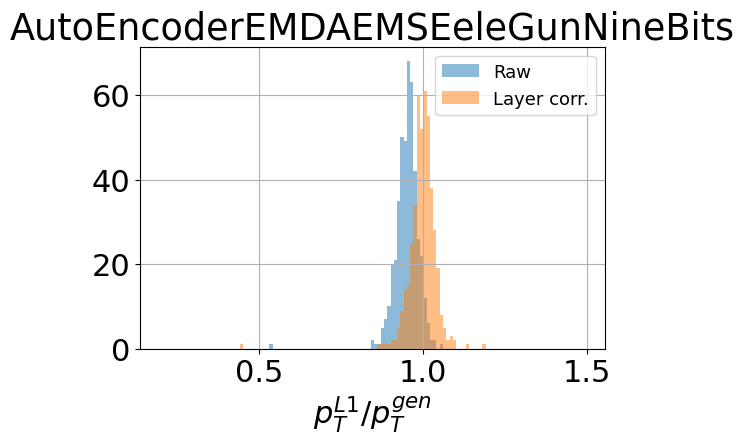

Raw mean=0.9559096097946167, rms=0.03661620244383812, rms/mean=0.03830508887767792
Calib mean=0.9973240841695871, rms=0.0437171507655926, rms/mean=0.04383444805907128


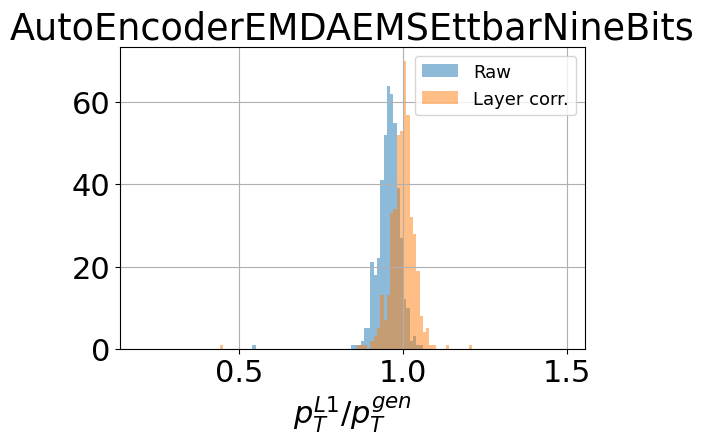

In [22]:
for name,df in algo_cut.items():
    select = df.query('genpart_pid==0')
    print('Raw mean={0}, rms={1}, rms/mean={2}'.format(
        select['cl3d_over_gen_pt'].mean(),
        select['cl3d_over_gen_pt'].std(),
        select['cl3d_over_gen_pt'].std()/select['cl3d_over_gen_pt'].mean()
    ))
    print('Calib mean={0}, rms={1}, rms/mean={2}'.format(
        select['calib_over_gen_pt'].mean(),
        select['calib_over_gen_pt'].std(),
        select['calib_over_gen_pt'].std()/select['calib_over_gen_pt'].mean()
    ))
    
    plt.figure(dpi=100)
    plt.hist(select['cl3d_over_gen_pt'], bins=np.arange(0.2, 1.5, 0.01), alpha=0.5, label='Raw')
    plt.hist(select['calib_over_gen_pt'], bins=np.arange(0.2, 1.5, 0.01), alpha=0.5, label='Layer corr.')
    plt.title(name)
    plt.legend(fontsize=13)
    plt.xlabel(r'$p_{T}^{L1}/p_{T}^{gen}$')
    plt.grid()
    plt.savefig(fig_dir+'/energy_ratio_'+name+'.png')
    plt.show()

## eta correction
On 200PU electrons, on top of the layer correction.

Simple linear correction vs eta to correct for PU. This correction is additive, not multiplicative.

In [23]:
corrs = {}
corrs['eta'] = {}
for name,df in algo_cut.items():
    print('  '+name)
    select = df.query('genpart_pid==1')
    X = select[['cl3d_abseta']]
    y = select['genpart_pt']-select['cl3d_pt_calib']
    corrs['eta'][name] = LinearRegression().fit(X, y)

  AutoEncoderEMDAEMSEeleGun
  AutoEncoderEMDAEMSEnew
  AutoEncoderEMDAEMSEeleGunNineBits
  AutoEncoderEMDAEMSEttbarNineBits


Print correction value at eta=1.5 and eta=3

In [24]:
for name,df in algo_cut.items():
    corr = corrs['eta'][name]
    print(name)
    print('  eta=1.5:', corr.intercept_+corr.coef_*1.5)
    print('  eta=3:', corr.intercept_+corr.coef_*3)

AutoEncoderEMDAEMSEeleGun
  eta=1.5: [3.0991535]
  eta=3: [-15.233627]
AutoEncoderEMDAEMSEnew
  eta=1.5: [3.3380375]
  eta=3: [-15.692751]
AutoEncoderEMDAEMSEeleGunNineBits
  eta=1.5: [2.40036]
  eta=3: [-15.258602]
AutoEncoderEMDAEMSEttbarNineBits
  eta=1.5: [2.2864933]
  eta=3: [-16.282753]


In [25]:
for name,df in algo_cut.items():
    df['cl3d_corr_eta'] = corrs['eta'][name].predict(df[['cl3d_abseta']])
    df['cl3d_pt_corr_eta'] =  df['cl3d_corr_eta']+df.cl3d_pt_calib
    df['corr_eta_over_gen_pt'] = df['cl3d_pt_corr_eta']/df['genpart_pt'] 

Raw mean=1.001336932182312, rms=0.13016557693481445, rms/mean=0.1299917846918106
Calib mean=1.0764564317500938, rms=0.1253790256957547, rms/mean=0.11647385068052829
Corr eta mean=0.9820114840634917, rms=0.08907878761708486, rms/mean=0.09071053553109516


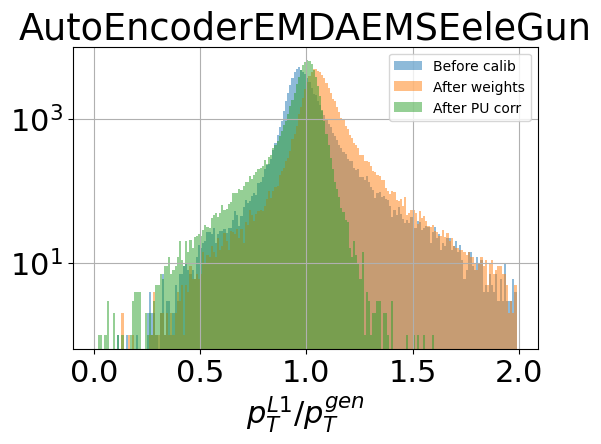

Raw mean=1.013917326927185, rms=0.13413432240486145, rms/mean=0.13229314982891083
Calib mean=1.0791085729165668, rms=0.12869238840419542, rms/mean=0.1192580539475943
Corr eta mean=0.9827484766751238, rms=0.08768576482144257, rms/mean=0.08922503255167055


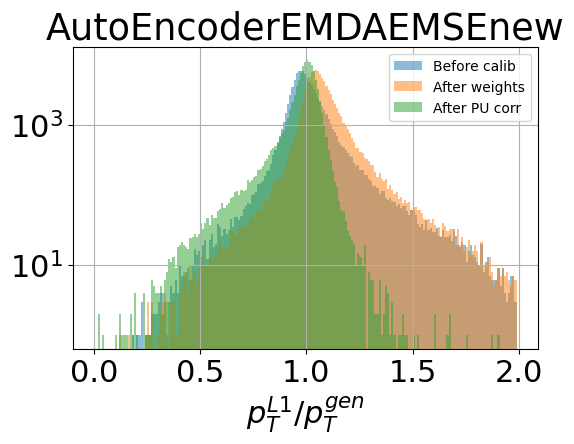

Raw mean=1.015209674835205, rms=0.12934093177318573, rms/mean=0.1274031698703766
Calib mean=1.0808851245350253, rms=0.12303987816611896, rms/mean=0.11383252056415172
Corr eta mean=0.9808594510039623, rms=0.08942715153480896, rms/mean=0.09117223822768437


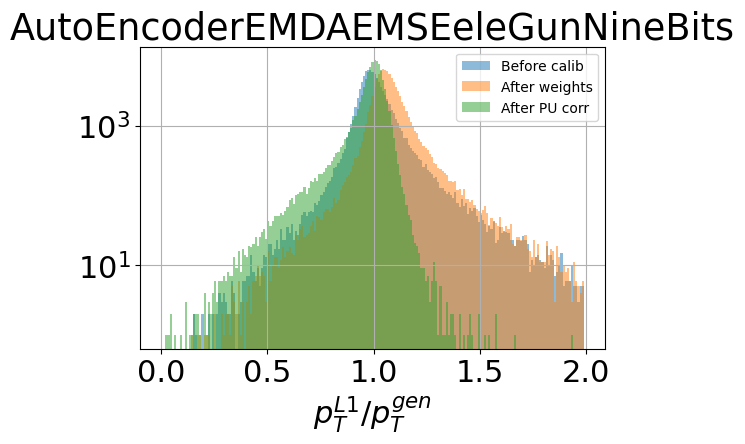

Raw mean=1.0259552001953125, rms=0.13276296854019165, rms/mean=0.12940426170825958
Calib mean=1.088414346684838, rms=0.12767939859129054, rms/mean=0.11730771372151114
Corr eta mean=0.9794880221348579, rms=0.09350038503559345, rms/mean=0.09545842616002928


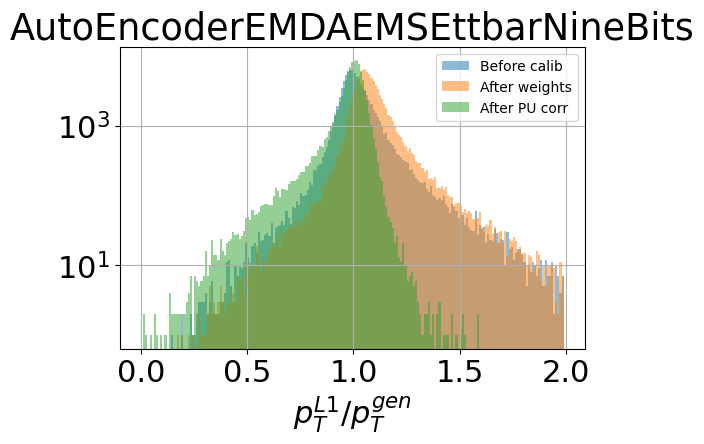

In [28]:
for name,df in algo_cut.items():
    select = df.query('genpart_pid==1 and genpart_pt>10')
    print('Raw mean={0}, rms={1}, rms/mean={2}'.format(
        select['cl3d_over_gen_pt'].mean(),
        select['cl3d_over_gen_pt'].std(),
        select['cl3d_over_gen_pt'].std()/select['cl3d_over_gen_pt'].mean()
    ))
    print('Calib mean={0}, rms={1}, rms/mean={2}'.format(
        select['calib_over_gen_pt'].mean(),
        select['calib_over_gen_pt'].std(),
        select['calib_over_gen_pt'].std()/select['calib_over_gen_pt'].mean()
    ))
    print('Corr eta mean={0}, rms={1}, rms/mean={2}'.format(
        select['corr_eta_over_gen_pt'].mean(),
        select['corr_eta_over_gen_pt'].std(),
        select['corr_eta_over_gen_pt'].std()/select['corr_eta_over_gen_pt'].mean()
    ))
    #plt.figure(figsize=(15,10))
    plt.figure(dpi=100)
    plt.hist(select['cl3d_over_gen_pt'], bins=np.arange(0., 2., 0.01), alpha=0.5, label='Before calib')
    plt.hist(select['calib_over_gen_pt'], bins=np.arange(0., 2., 0.01), alpha=0.5, label='After weights')
    plt.hist(select['corr_eta_over_gen_pt'], bins=np.arange(0., 2., 0.01), alpha=0.5, label='After PU corr')
    plt.grid()
    plt.legend(loc = 'upper right', fontsize=10)
    plt.yscale('log')
    plt.title(name)
    plt.xlabel(r'$p_{T}^{L1}/p_{T}^{gen}$')
    plt.savefig(fig_dir+'/eta_corrections'+name+'.png')
    plt.show()

## Final plots
For electrons with 200PU, looking at $p_T > 10\,GeV$
First bin in eta and pT

In [29]:
binetasize = 0.1
binptsize = 5
for name,df in algo_cut.items():
    df['genpart_abseta'] = np.abs(df.genpart_exeta)
    df['genpart_bineta'] = ((df.genpart_abseta - etamin)/binetasize).astype('int32')
    df['genpart_binpt'] = (df.genpart_pt/binptsize).astype('int32')

Compute the mean, RMS, and effective RMS of the pT ratios in each eta and pT bin

In [30]:
def effrms(df, c=0.68):
    """Compute half-width of the shortest interval
    containing a fraction 'c' of items in a 1D array.
    """
    out = {}
    for col in df:
        x = df[col]
        x = np.sort(x, kind="mergesort")
        m = int(c * len(x)) + 1
        out[col] = [np.min(np.subtract(x[m:],x[:-m])) / 2.0]
    return pd.DataFrame(out).iloc[0]

In [31]:
etameans = {} 
etarmss = {} 
etaeffrmss = {} 
ptmeans = {} 
ptrmss = {} 
pteffrmss = {}
both_means={}
both_eff_rms={}
both_full_rms={}
plot_var = ['genpart_pt', 'genpart_abseta',
            'genpart_bineta', 'genpart_binpt',
           'cl3d_pt', 'cl3d_abseta', 'cl3d_pt_calib',
           'cl3d_pt_corr_eta', 'cl3d_over_gen_pt',
           'calib_over_gen_pt', 'corr_eta_over_gen_pt']


for name,df in algo_cut.items():
    select = df.query('genpart_pid==1 and genpart_pt>10')
    etameans[name] = select[plot_var].groupby('genpart_bineta').mean()
    etarmss[name] = select[plot_var].groupby('genpart_bineta').std()
    etaeffrmss[name] = select[plot_var].groupby('genpart_bineta').apply(effrms)
    ptmeans[name] = select[plot_var].groupby('genpart_binpt').mean()
    ptrmss[name] = select[plot_var].groupby('genpart_binpt').std()
    pteffrmss[name] = select[plot_var].groupby('genpart_binpt').apply(effrms)
    both_means[name]=select[plot_var].groupby(['genpart_binpt','genpart_bineta']).mean()
    both_eff_rms[name]=select[plot_var].groupby(['genpart_binpt','genpart_bineta']).apply(effrms)
    both_full_rms[name]=select[plot_var].groupby(['genpart_binpt','genpart_bineta']).std()

In [32]:
plotted_algo = fes

Mean vs eta


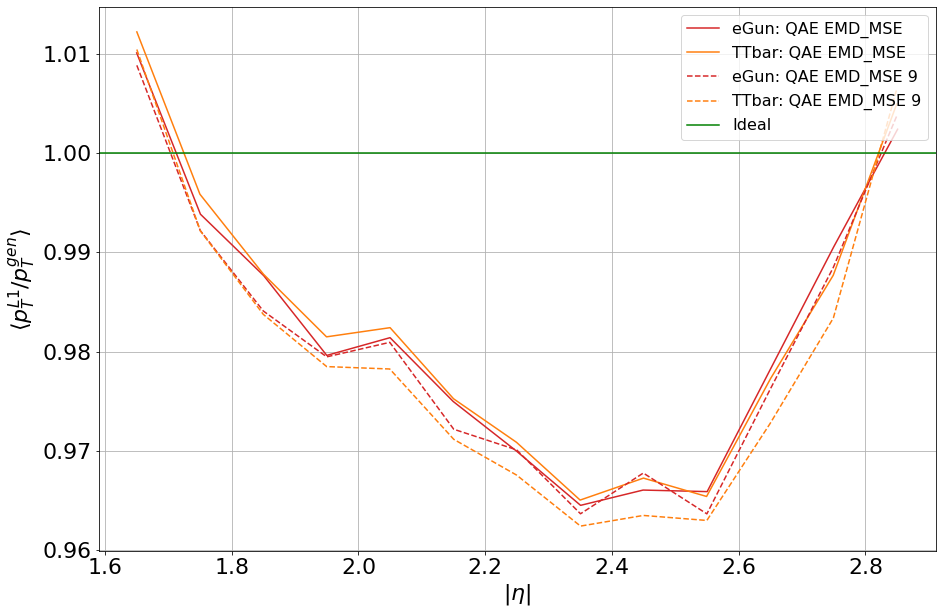

RMS vs eta


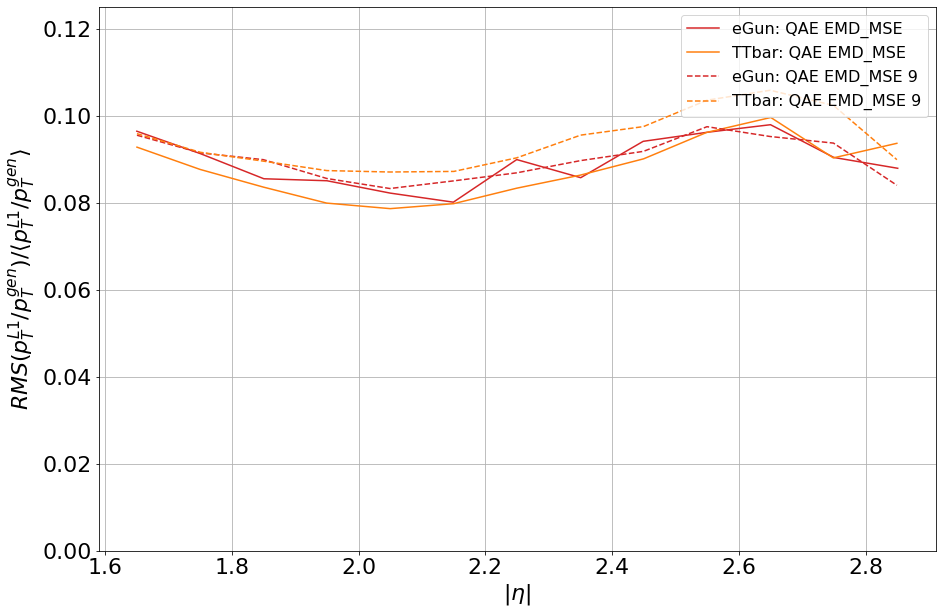

Eff RMS vs eta


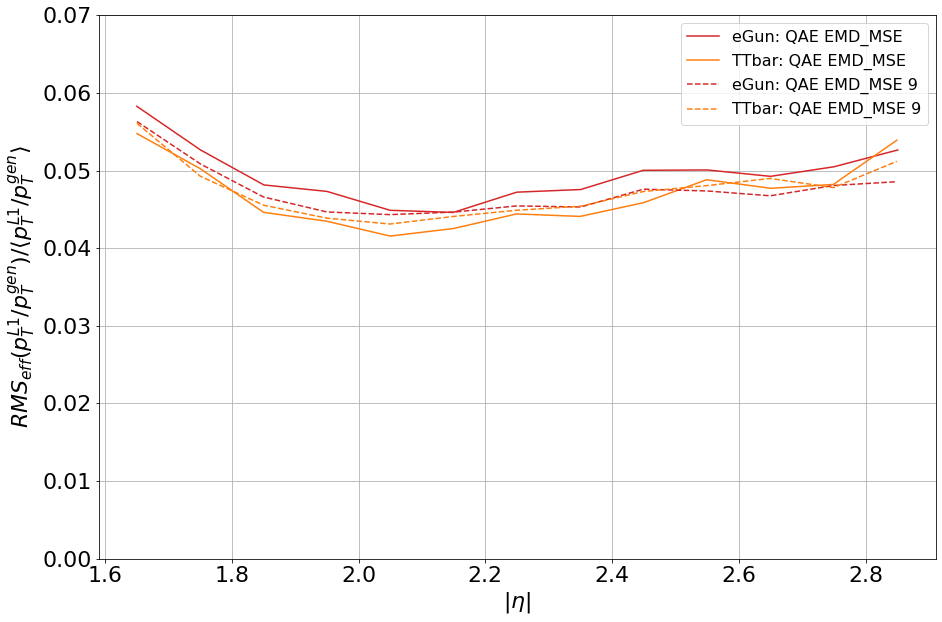

Mean vs pt


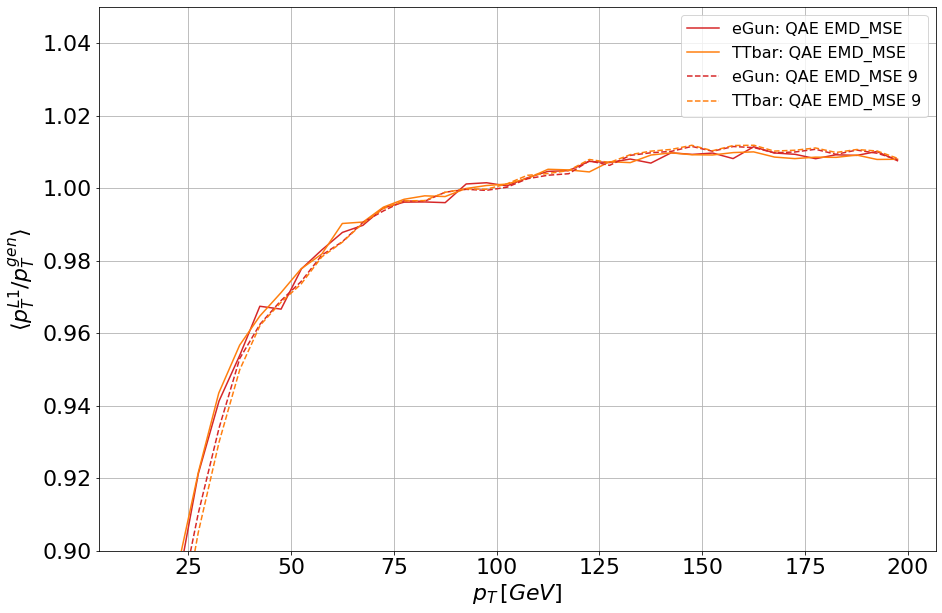

RMS vs pt


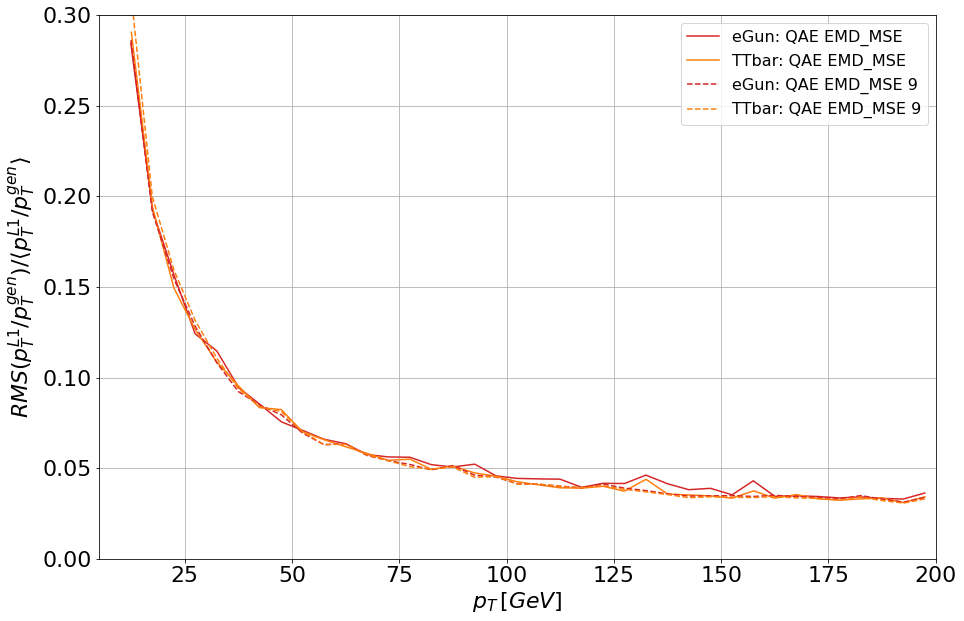

Eff RMS vs pt


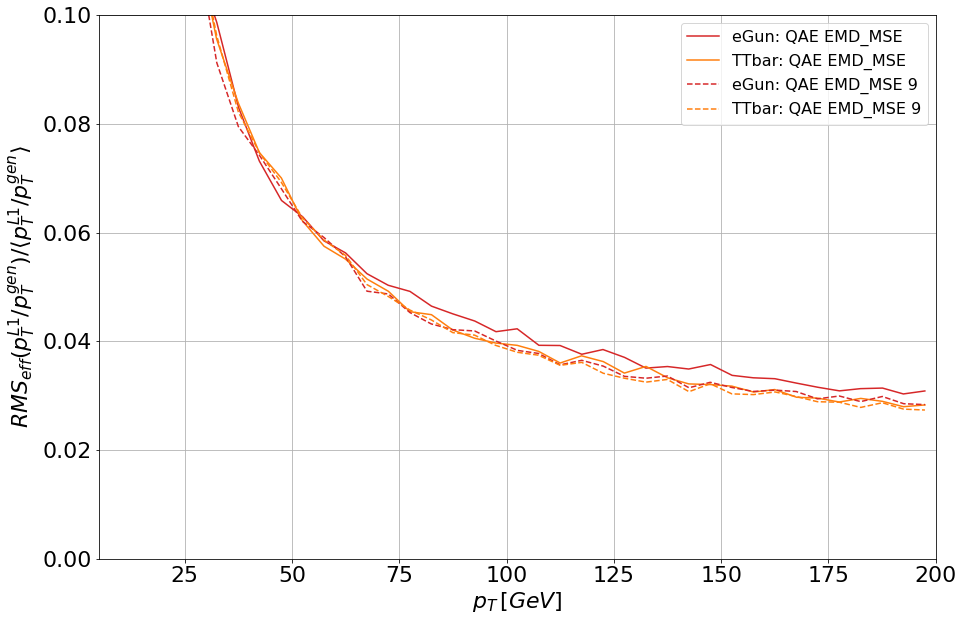

In [34]:
print('Mean vs eta')
plt.figure(figsize=(15,10))
for name in plotted_algo:
    df = etameans[name]
    plt.plot(df['genpart_abseta'], df['corr_eta_over_gen_pt'], color=colors[name], ls=styles[name], label=legends[name])
#plt.ylim(0.95, 1.025)
plt.axhline(y=1, color='g', linestyle='-',label='Ideal')
plt.legend(loc = 'upper right', fontsize=16)
plt.xlabel(r'$|\eta|$')
plt.ylabel(r'$\langle p_{T}^{L1}/p_{T}^{gen}\rangle$')
plt.grid(visible=True)
plt.savefig(fig_dir+'/mean_v_eta.png')
plt.show()
print('RMS vs eta')
plt.figure(figsize=(15,10))
for name in plotted_algo:
    df = etameans[name]
    plt.plot(df['genpart_abseta'], etarmss[name]['corr_eta_over_gen_pt']/df['corr_eta_over_gen_pt'], color=colors[name], ls=styles[name], label=legends[name])
plt.ylim(0., 0.125)
plt.legend(loc = 'upper right', fontsize=16)
plt.xlabel(r'$|\eta|$')
plt.ylabel(r'$RMS(p_{T}^{L1}/p_{T}^{gen}) / \langle p_{T}^{L1}/p_{T}^{gen}\rangle$')
plt.grid(visible=True)
plt.savefig(fig_dir+'/rms_v_eta.png')
plt.show()
print('Eff RMS vs eta')
plt.figure(figsize=(15,10))
for name in plotted_algo:
    df = etameans[name]
    plt.plot(df['genpart_abseta'], etaeffrmss[name]['corr_eta_over_gen_pt']/df['corr_eta_over_gen_pt'], color=colors[name], ls=styles[name], label=legends[name])
plt.ylim(0., 0.07)
plt.legend(loc = 'upper right', fontsize=16)
plt.xlabel(r'$|\eta|$')
plt.ylabel(r'$RMS_{eff}(p_{T}^{L1}/p_{T}^{gen}) / \langle p_{T}^{L1}/p_{T}^{gen}\rangle$')
plt.grid(visible=True)
plt.savefig(fig_dir+'/rms_eff_v_eta.png')
plt.show()
print('Mean vs pt')
plt.figure(figsize=(15,10))
for name in plotted_algo:
    df = ptmeans[name]
    plt.plot(df['genpart_pt'], df['corr_eta_over_gen_pt'], color=colors[name], ls=styles[name], label=legends[name])
plt.ylim(0.9, 1.05)
plt.legend(loc = 'upper right', fontsize=16)
plt.xlabel(r'$p_{T}\, [GeV]$')
plt.ylabel(r'$\langle p_{T}^{L1}/p_{T}^{gen}\rangle$')
plt.grid(visible=True)
plt.savefig(fig_dir+'/mean_v_pT.png')
plt.show()
print('RMS vs pt')
plt.figure(figsize=(15,10))
for name in plotted_algo:
    df = ptmeans[name]
    plt.plot(df['genpart_pt'], ptrmss[name]['corr_eta_over_gen_pt']/df['corr_eta_over_gen_pt'], color=colors[name], ls=styles[name], label=legends[name])
plt.ylim(0., 0.3)
plt.xlim(5., 200)
plt.legend(loc = 'upper right', fontsize=16)
plt.xlabel(r'$p_{T}\, [GeV]$')
plt.ylabel(r'$RMS(p_{T}^{L1}/p_{T}^{gen}) / \langle p_{T}^{L1}/p_{T}^{gen}\rangle$')
plt.grid(visible=True)
plt.savefig(fig_dir+'/rms_v_pT.png')
plt.show()
print('Eff RMS vs pt')
plt.figure(figsize=(15,10))
for name in plotted_algo:
    df = ptmeans[name]
    plt.plot(df['genpart_pt'], pteffrmss[name]['corr_eta_over_gen_pt']/df['corr_eta_over_gen_pt'], color=colors[name], ls=styles[name], label=legends[name])
plt.ylim(0.0, 0.1)
plt.xlim(5.,200)
plt.legend(loc = 'upper right', fontsize=16)
plt.xlabel(r'$p_{T}\, [GeV]$')
plt.ylabel(r'$RMS_{eff}(p_{T}^{L1}/p_{T}^{gen}) / \langle p_{T}^{L1}/p_{T}^{gen}\rangle$')
plt.grid(visible=True)
plt.savefig(fig_dir+'/rms_eff_v_pT.png')
plt.show()

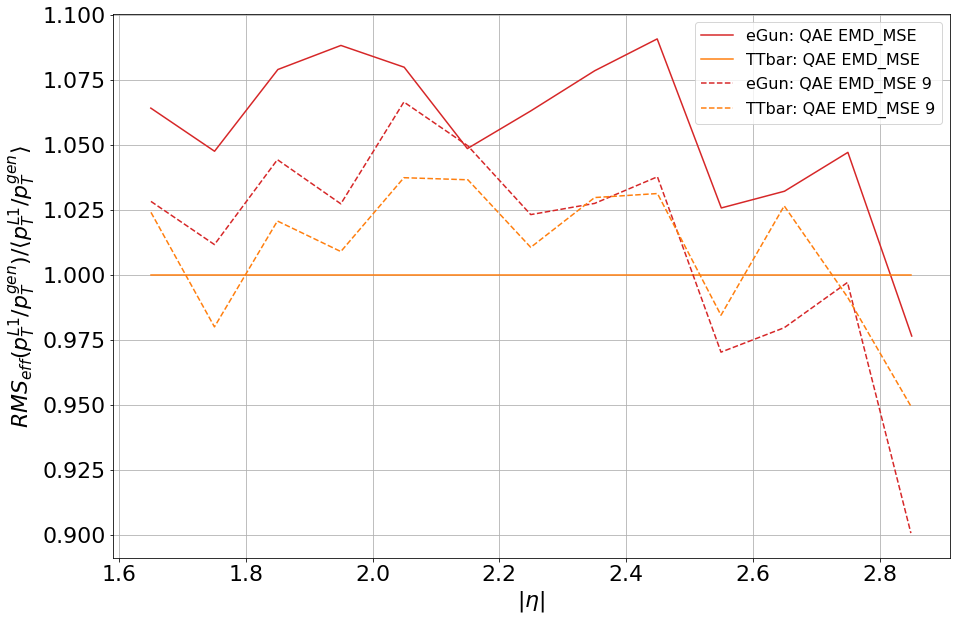

In [37]:
#Ratio effective RMS vs eta

Ratio_Against = ['AutoEncoderEMDAEMSEnew']

for ratio_against in Ratio_Against:
    df_denom=df = etameans[ratio_against]
    denom=(etaeffrmss[ratio_against]['corr_eta_over_gen_pt']/df_denom['corr_eta_over_gen_pt'])
    plt.figure(figsize=(15,10))
    for name in plotted_algo:
        df = etameans[name]
        ratio_eff_rms = (etaeffrmss[name]['corr_eta_over_gen_pt']/df['corr_eta_over_gen_pt'])/denom
        plt.plot(df['genpart_abseta'],ratio_eff_rms,  color=colors[name], ls=styles[name], label=legends[name])
    
    plt.legend(loc = 'upper right', fontsize=16)
    plt.xlabel(r'$|\eta|$')
    plt.ylabel(r'$RMS_{eff}(p_{T}^{L1}/p_{T}^{gen}) / \langle p_{T}^{L1}/p_{T}^{gen}\rangle$')
    plt.grid()
    plt.savefig(fig_dir+'/ratio_'+ratio_against+'rms_eff_v_eta.png')
    plt.show()
    
    

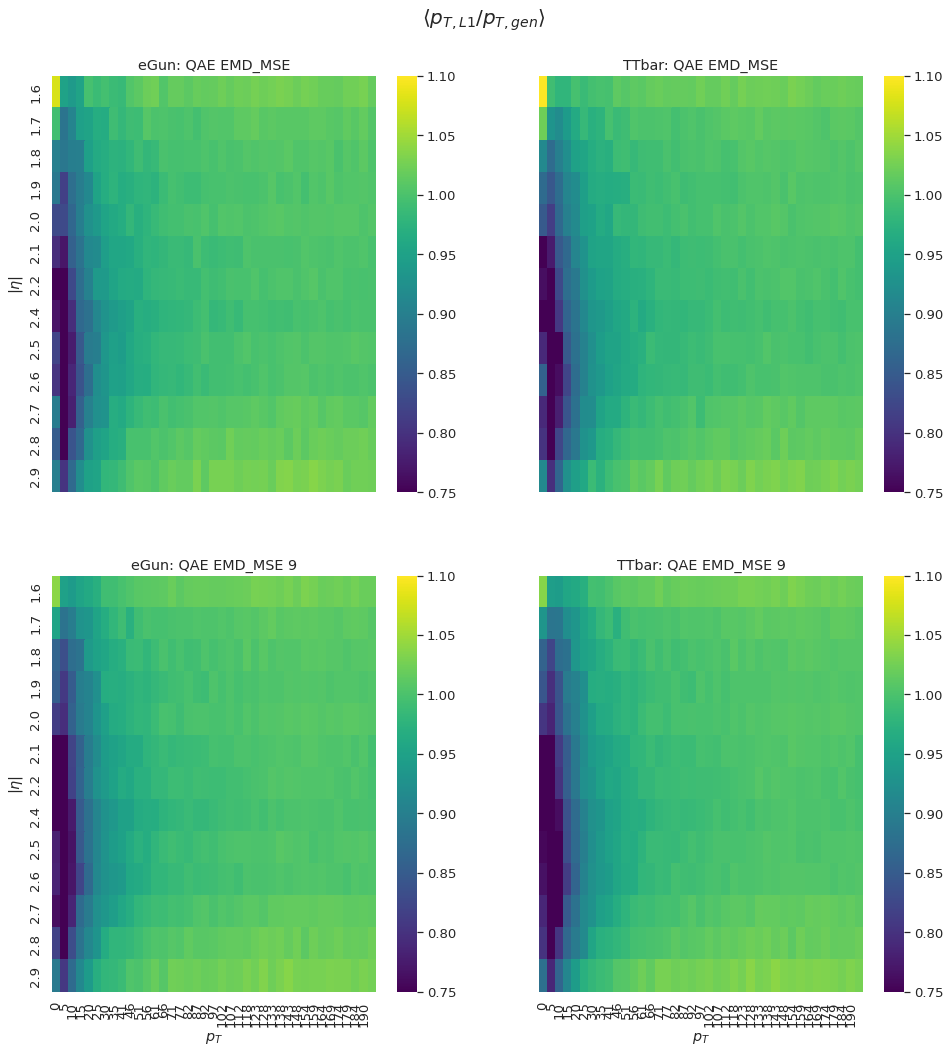

In [40]:
#Mean heatmaps
sns.set(font_scale=1.2)
fig, axes = plt.subplots(2, 2, figsize=(16, 16), facecolor='white', sharex=True, sharey=True)
fig.suptitle(r'$\langle p_{T,L1}/p_{T,gen}\rangle$', fontsize=20)

# calculate pt ratio and 68% CI
eta_bins = [f'{neta:0.1f}' for neta in np.linspace(etamin, etamax, 13)]
pt_bins = np.linspace(0., 190, 38).astype(int)

for ix, (algo, df_algo) in enumerate(algo_cut.items()):
    
    
    ax = axes[ix//2][ix%2]
    df = df_algo.query('(cl3d_pt_corr_eta > 5) and (genpart_pt > 5)')
    df = df.groupby(['genpart_binpt', 'genpart_bineta']).mean()
    df = df.reset_index().pivot(columns='genpart_binpt', index='genpart_bineta', values='corr_eta_over_gen_pt')
    sns.heatmap(df, ax=ax, cmap='viridis', 
                xticklabels=pt_bins,
                yticklabels=eta_bins,
                vmin=0.75, 
                vmax=1.1, 
                #cbar=bool(ix%2)
               )
    ax.set_title(legends[algo])
    ax.set_xlabel('')
    ax.set_ylabel('')
    plt.yticks(rotation=0)
    
    if ix%2 == 0:
        ax.set_ylabel('$|\eta|$')
    
    if ix//2 > 0:
        ax.set_xlabel(r'$p_{T}$')
plt.savefig(fig_dir+'/mean_pt_eta.pdf')
fig.subplots_adjust(top=0.92)
plt.show()


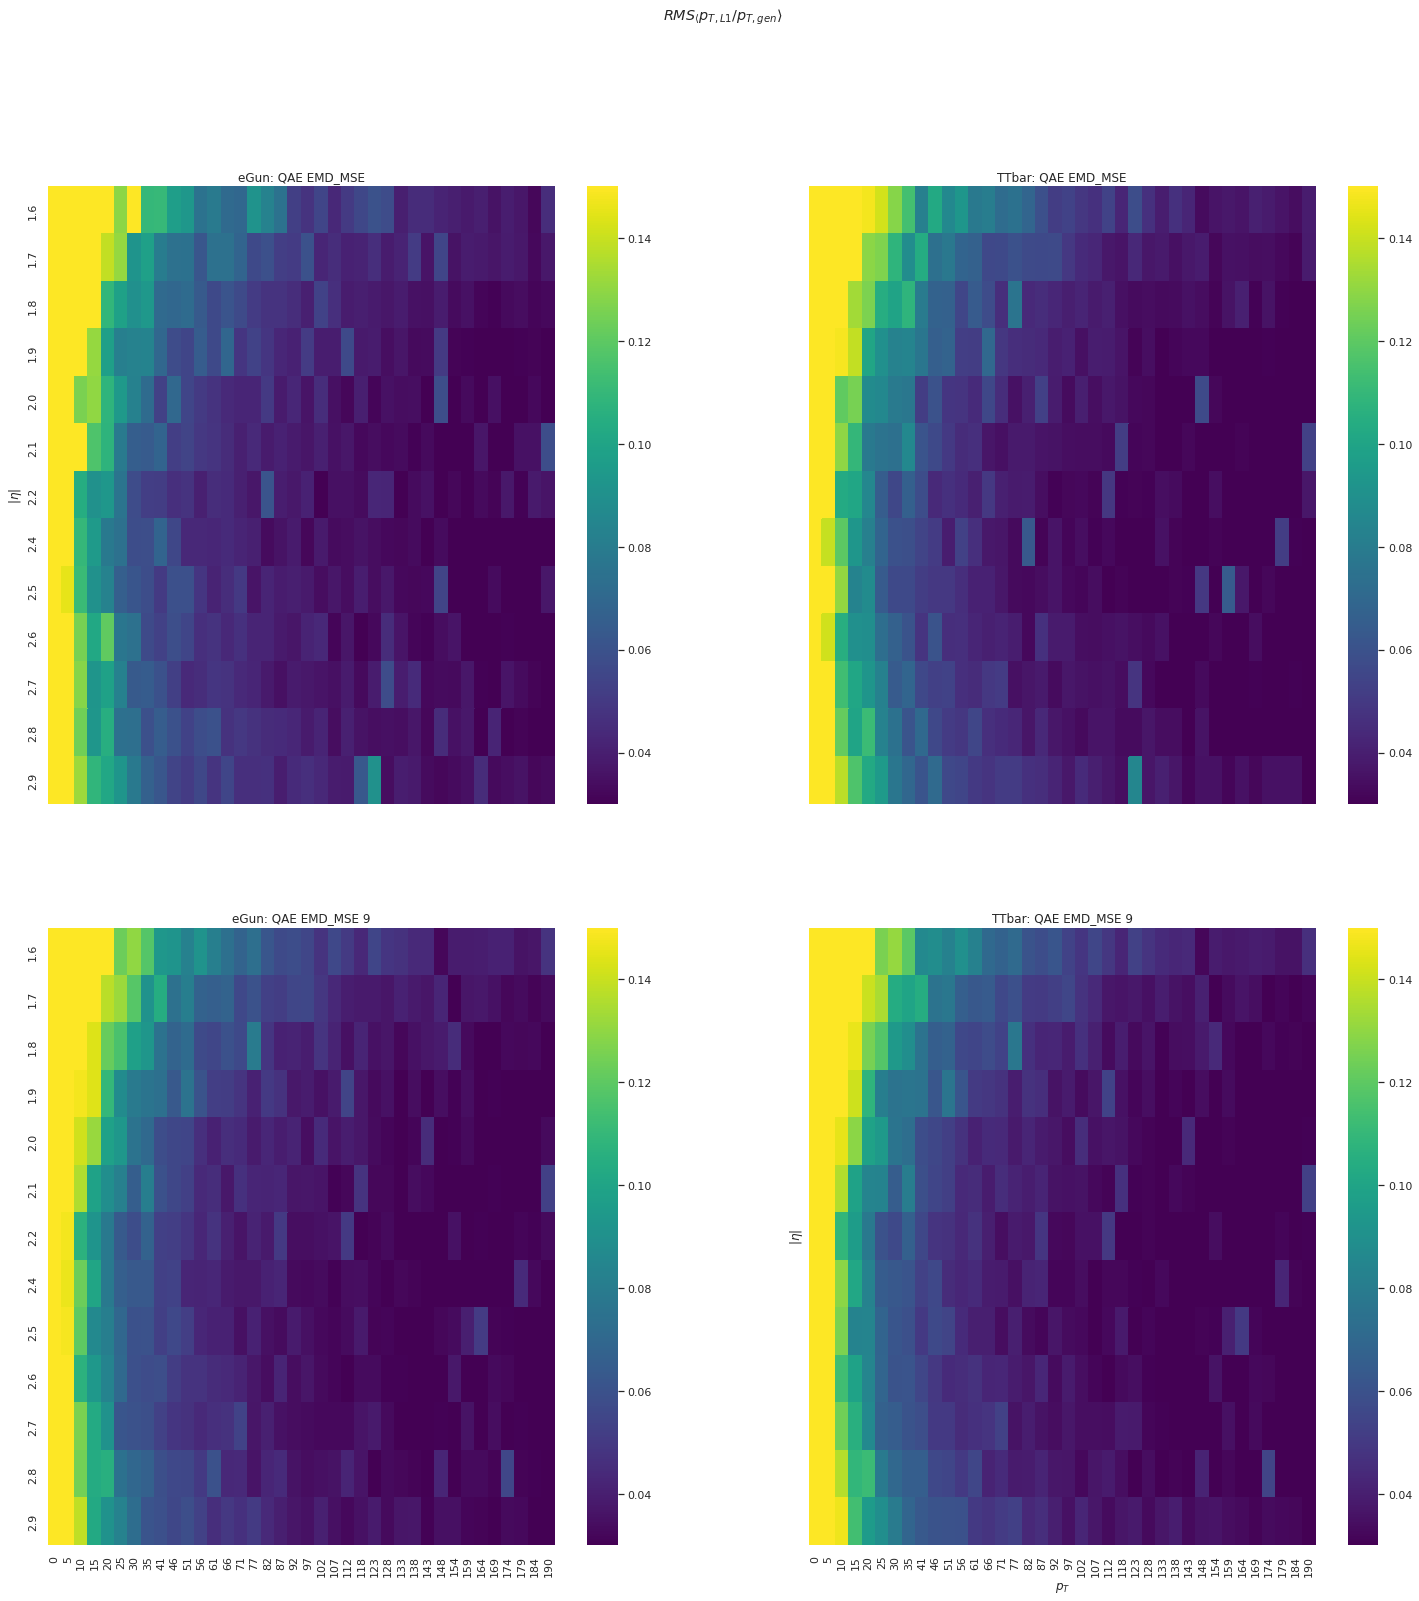

In [41]:
#RMS/Mean heatmaps

sns.set(font_scale=1.0)
fig, axes = plt.subplots(2, 2, figsize=(25, 25), facecolor='white', sharex=True, sharey=True)
fig.suptitle(r'$RMS_\langle p_{T,L1}/p_{T,gen}\rangle}$')

for ix, (name, df_algo) in enumerate(algo_cut.items()):
    
    ax = axes[ix//2][ix%2]
    df = both_full_rms[name]['corr_eta_over_gen_pt']/(both_means[name]['corr_eta_over_gen_pt'])
    df = df.reset_index().pivot(columns='genpart_binpt', index='genpart_bineta')
    sns.heatmap(df, ax=ax, cmap='viridis', 
                xticklabels=pt_bins,
                yticklabels=eta_bins,
                vmin=0.03, 
                vmax=0.15, 
                #cbar=bool(ix%2)
               )
    ax.set_title(legends[name])
    ax.set_xlabel('')
    ax.set_ylabel('')
    plt.yticks(rotation=0)
    
    if ix%3 == 0:
        ax.set_ylabel('$|\eta|$')
    
    if ix//3 > 0:
        ax.set_xlabel(r'$p_{T}$')

plt.savefig(fig_dir+'/rms_pt_eta.pdf',dpi=300)
plt.show()

In [ ]:
#Ratio RMS/Mean heatmaps
DENOM_0=(both_full_rms['Threshold0']['corr_eta_over_gen_pt'])/(both_means['Threshold0']['corr_eta_over_gen_pt'])

sns.set(font_scale=1.0)
fig, axes = plt.subplots(2, 2, figsize=(25, 25), facecolor='white', sharex=True, sharey=True)
fig.suptitle(r'$\frac{RMS_\langle p_{T,L1}/p_{T,gen}\rangle}{ALL TC}$')

for ix, (name, df_algo) in enumerate(algo_cut.items()):
    
    ax = axes[ix//2][ix%2]
    df = (both_full_rms[name]['corr_eta_over_gen_pt']/(both_means[name]['corr_eta_over_gen_pt']))/DENOM_0
    df = df.reset_index().pivot(columns='genpart_binpt', index='genpart_bineta')
    sns.heatmap(df, ax=ax, cmap='viridis', 
                xticklabels=pt_bins,
                yticklabels=eta_bins,
                vmin=0.8, 
                vmax=1, 
                #cbar=bool(ix%2)
               )
    ax.set_title(legends[name])
    ax.set_xlabel('')
    ax.set_ylabel('')
    plt.yticks(rotation=0)
    
    if ix%3 == 0:
        ax.set_ylabel('$|\eta|$')
    
    if ix//3 > 0:
        ax.set_xlabel(r'$p_{T}$')

plt.savefig(fig_dir+'/ratio_rms_pt_eta.png')
plt.show()

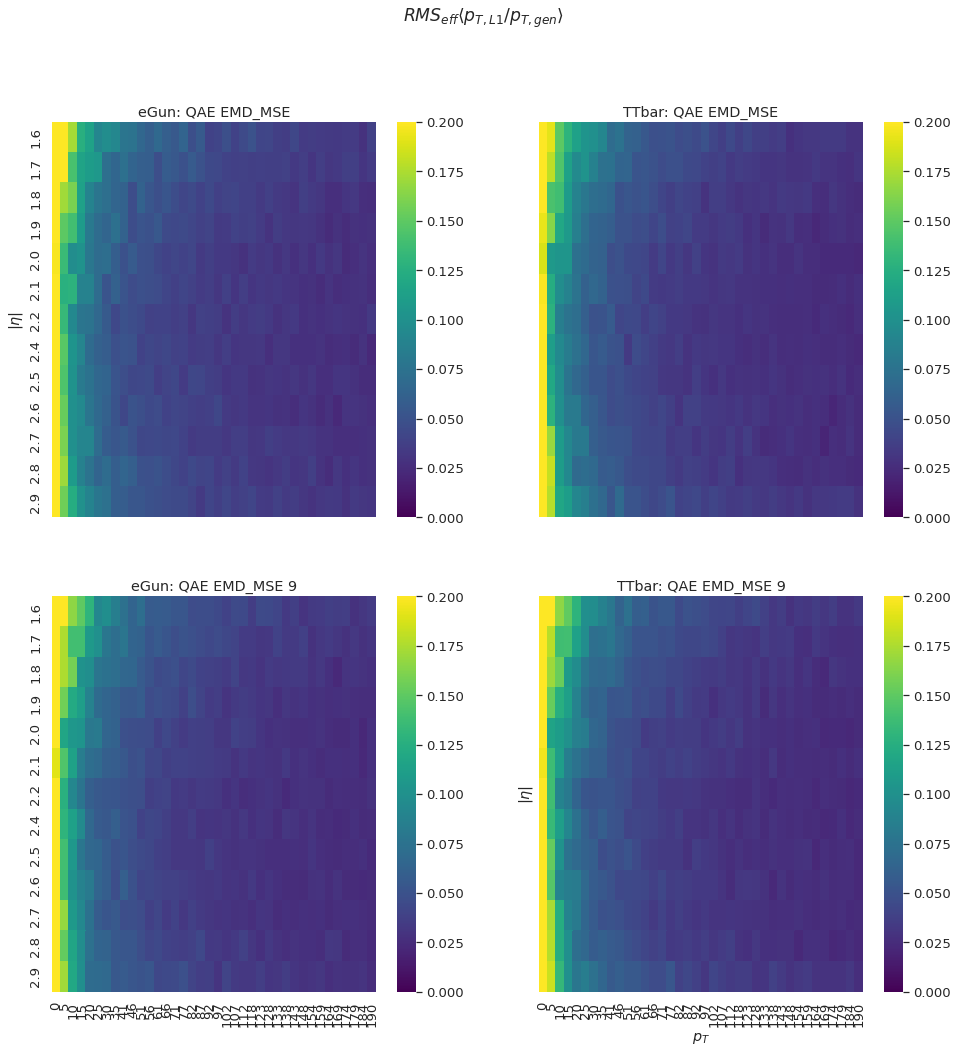

In [42]:
#RMS_eff/mean heatmaps
sns.set(font_scale=1.2)
fig, axes = plt.subplots(2, 2, figsize=(16, 16), facecolor='white', sharex=True, sharey=True)
fig.suptitle(r'$RMS_{eff}\langle p_{T,L1}/p_{T,gen}\rangle$')

for ix, (name, df_algo) in enumerate(algo_cut.items()):
    
    ax = axes[ix//2][ix%2]
    df = both_eff_rms[name]['corr_eta_over_gen_pt']/both_means[name]['corr_eta_over_gen_pt']
    df = df.reset_index().pivot(columns='genpart_binpt', index='genpart_bineta')
    sns.heatmap(df, ax=ax, cmap='viridis', 
                xticklabels=pt_bins,
                yticklabels=eta_bins,
                vmin=0, 
                vmax=0.2, 
                #cbar=bool(ix%2)
               )
    ax.set_title(legends[name])
    ax.set_xlabel('')
    ax.set_ylabel('')
    plt.yticks(rotation=0)
    
    if ix%3 == 0:
        ax.set_ylabel('$|\eta|$')
    
    if ix//3 > 0:
        ax.set_xlabel(r'$p_{T}$')

plt.savefig(fig_dir+'/rms_eff_pt_eta.pdf')
plt.show()

In [ ]:
DENOM=both_eff_rms['Threshold0']['corr_eta_over_gen_pt']/both_means['Threshold0']['corr_eta_over_gen_pt']

In [ ]:
#Ratio RMS_eff/mean heatmaps

sns.set(font_scale=1.0)
fig, axes = plt.subplots(2, 2, figsize=(25, 25), facecolor='white', sharex=True, sharey=True)
fig.suptitle(r'${RMS_{eff}(p_{T}^{L1}/p_{T}^{gen}) / \langle p_{T}^{L1}/p_{T}^{gen}\rangle}$/"___"ALL TC')
for ix, (name, df_algo) in enumerate(algo_cut.items()):
    
    ax = axes[ix//2][ix%2]
    df = ((both_eff_rms[name]['corr_eta_over_gen_pt']/both_means[name]['corr_eta_over_gen_pt'])/DENOM)
    df = df.reset_index().pivot(columns='genpart_binpt', index='genpart_bineta')
    #sns.color_palette("Spectral", as_cmap=True)
    sns.heatmap(df, ax=ax, cmap='viridis', 
                xticklabels=pt_bins,
                yticklabels=eta_bins,
                vmin=0.8, 
                vmax=1, 
                #cbar=bool(ix%2)
               )
               
    ax.set_title(legends[name])
    ax.set_xlabel('')
    ax.set_ylabel('')
    plt.yticks(rotation=0)
    
    if ix%3 == 0:
        ax.set_ylabel('$|\eta|$')
    
    if ix//3 > 0:
        ax.set_xlabel(r'$p_{T}$')

plt.savefig(fig_dir+'/ratio_rms_eff_pt_eta.png')
plt.show()

In [ ]:
#Individual plots of the ones above: Ratio RMS_eff heatmaps
plt.close()
#sns.set(font_scale=1.0)
for ix, (name, df_algo) in enumerate(algo_cut.items()):
    
    fig, axes = plt.subplots()    
    df = ((both_eff_rms[name]['corr_eta_over_gen_pt']/both_means[name]['corr_eta_over_gen_pt'])/DENOM)
    df = df.reset_index().pivot(columns='genpart_binpt', index='genpart_bineta')
    axes.tick_params(left=True,bottom=True, width =0.5,length=0.8)
    sns.heatmap(df, cmap = 'viridis',
                xticklabels=[  0,None ,  None,  None,  20, None, None,  None,  40,  None,  None,  None,  60,
        None,  None,  None,  80, None,  None,  None, 100, None, None, None, 120, None,
       None, None, 140, None, None, None, 160, None, None, None,None, 190],
                yticklabels=eta_bins,
                vmin=0.8, 
                vmax=1,
                #cbar=bool(ix%2)
               )
    #plt.title(legends[name])
    plt.xlabel(r'$p_{T}$')
    plt.ylabel('$|\eta|$')
    plt.yticks(rotation=0)
    plt.xticks(rotation=0)
    plt.title(r'$\frac{RMS_{eff}(AE\_tele)}{RMS_{eff}(ALL\_TC)}$',fontsize=18,y=1.03)
    plt.savefig(fig_dir+'/ratio_pt_rms_eff_pt_eta'+name+'.png',dpi=600)
    plt.show()
    df={}

In [ ]:
#Ratio relative RMS_eff/mean heatmaps diverging heatmaps

sns.set(font_scale=1.0)
fig, axes = plt.subplots(2, 2, figsize=(25, 25), facecolor='white', sharex=True, sharey=True)
fig.suptitle(r'${RMS_{eff}(p_{T}^{L1}/p_{T}^{gen}) / \langle p_{T}^{L1}/p_{T}^{gen}\rangle}$/"___"ALL TC')
for ix, (name, df_algo) in enumerate(algo_cut.items()):
    
    ax = axes[ix//2][ix%2]
    df = ((both_eff_rms[name]['corr_eta_over_gen_pt']/both_means[name]['corr_eta_over_gen_pt'])/DENOM)-(DENOM/DENOM)
    df = df.reset_index().pivot(columns='genpart_binpt', index='genpart_bineta')
    #sns.color_palette("Spectral", as_cmap=True)
    sns.heatmap(df, ax=ax, cmap='Spectral', 
                xticklabels=pt_bins,
                yticklabels=eta_bins,
                #cbar=bool(ix%2)
               )
               
    ax.set_title(legends[name])
    ax.set_xlabel('')
    ax.set_ylabel('')
    plt.yticks(rotation=0)
    
    if ix%3 == 0:
        ax.set_ylabel('$|\eta|$')
    
    if ix//3 > 0:
        ax.set_xlabel(r'$p_{T}$')

plt.savefig(fig_dir+'/rel_ratio_pt_rms_eff__pt_eta.pdf')
plt.show()

In [ ]:
#Individual plots of the ones above: Ratio RMS_eff heatmaps
plt.close()
#sns.set(font_scale=1.0)
for ix, (name, df_algo) in enumerate(algo_cut.items()):
    
    fig, axes = plt.subplots()    
    df = ((both_eff_rms[name]['corr_eta_over_gen_pt']/both_means[name]['corr_eta_over_gen_pt'])/DENOM)-(DENOM/DENOM)
    df = df.reset_index().pivot(columns='genpart_binpt', index='genpart_bineta')
    axes.tick_params(left=True,bottom=True, width =0.5,length=0.8)
    sns.heatmap(df, cmap = 'Spectral',
                xticklabels=[  0,None ,  None,  None,  20, None, None,  None,  40,  None,  None,  None,  60,
        None,  None,  None,  80, None,  None,  None, 100, None, None, None, 120, None,
       None, None, 140, None, None, None, 160, None, None, None,None, 190],
                yticklabels=eta_bins,
                #cbar=bool(ix%2)
               )
    #plt.title(legends[name])
    plt.xlabel(r'$p_{T}$')
    plt.ylabel('$|\eta|$')
    plt.yticks(rotation=0)
    plt.xticks(rotation=0)
    plt.title(r'$\frac{RMS_{eff}(AE\_tele)}{RMS_{eff}(ALL\_TC)}-1$',fontsize=18,y=1.03)
    plt.savefig(fig_dir+'/rel_ratio_pt_rms_eff__pt_eta'+name+'.png')
    plt.show()
    df={}



Storing layer weights and eta corrections for external use

In [ ]:
with open(fig_dir+'/layer_weights_photons_autoencoder_{}.pkl'.format(version), 'wb') as f:
    pickle.dump(layer_coeffs, f)
    # add  protocol=2 if needed later for python2 in cmssw
with open(fig_dir+'/lineareta_electrons_autoencoder_{}.pkl'.format(version), 'wb') as f:
    pickle.dump(corrs['eta'], f)